<a href="https://colab.research.google.com/github/tahaky/graduation-project/blob/main/pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*Imports*

In [24]:
import re
import nltk
import string
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

from collections import Counter
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report
from sklearn.naive_bayes import MultinomialNB

In [2]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
stop_words = stopwords.words('turkish')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


*Read csv file*

In [3]:
train_df = pd.read_csv('./data-set.csv', on_bad_lines='skip')
#Display the first few rows of the dataset
print(train_df.head())

#Summary statistics
print(train_df.describe())

#Information about the dataset
print(train_df.info())

print(train_df.duplicated().sum())

good_reviews=train_df[train_df['Durum']==1]['Metin']
bad_reviews=train_df[train_df['Durum']==2]['Metin']
notr_reviews=train_df[train_df['Durum']==0]['Metin']

print("First 10 samples of good reviews\n".format(),good_reviews[:10])
print("First 10 samples of bad reviews\n".format(),bad_reviews[:10])
print("First 10 samples of notr reviews\n".format(),notr_reviews[:10])




                                               Metin  Durum
0                              evet anlatıldığı gibi      1
1  Daha öncede almıştım bu cihazdan ense ve sakal...      1
2  Ürün gayet başarılı sakal kesmede başlık sayıs...      1
3  Daha öncede aynısını almıştım çok güzel ve kal...      1
4  Erkek kuaförüyüm ense ve sıfır sakal traşı içi...      1
              Durum
count  13725.000000
mean       0.626011
std        0.640908
min        0.000000
25%        0.000000
50%        1.000000
75%        1.000000
max        2.000000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13725 entries, 0 to 13724
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Metin   13725 non-null  object
 1   Durum   13725 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 214.6+ KB
None
1485
First 10 samples of good reviews
 0                                 evet anlatıldığı gibi
1     Daha öncede almıştım bu cihazdan ense ve sakal...


Total Counts of both sets Metin
Güzel bir ürün                                                                                                                                   18
idare eder                                                                                                                                       17
İdare eder                                                                                                                                       16
Gayet güzel                                                                                                                                      15
Güzel ürün                                                                                                                                       14
                                                                                                                                                 ..
F/p ürünü fena değil                                                            

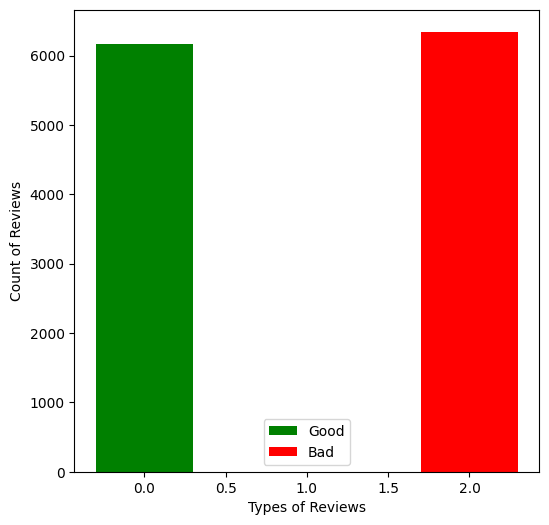

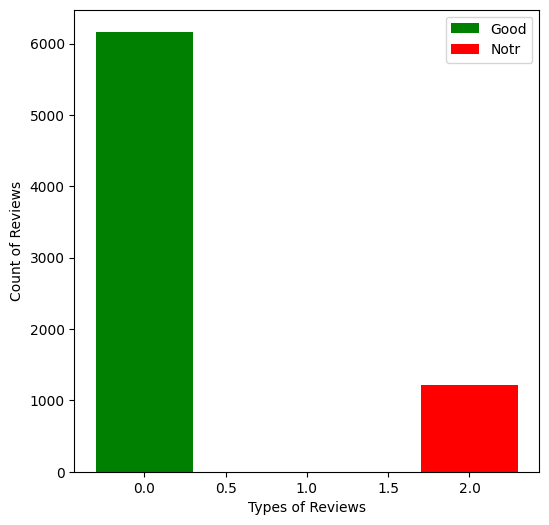

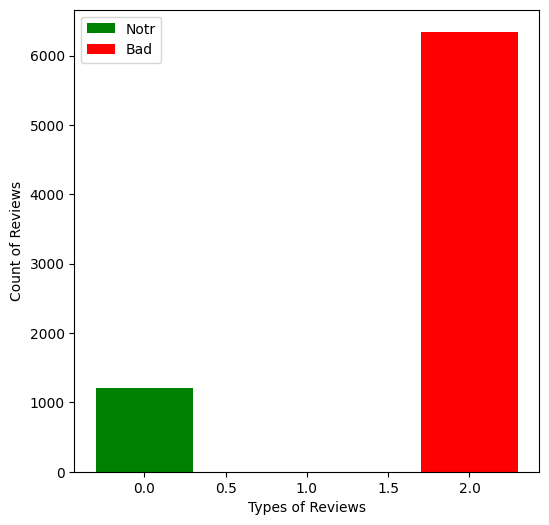

In [4]:
#Count of good and bad reviews
count=train_df['Metin'].value_counts()
print('Total Counts of both sets'.format(),count)

print("==============")
#Creating a function to plot the counts using matplotlib
def plot_counts(count_good,count_bad,sl_name,sr_name):
    plt.rcParams['figure.figsize']=(6,6)
    plt.bar(0,count_good,width=0.6,label=sl_name,color='Green')
    plt.legend()
    plt.bar(2,count_bad,width=0.6,label=sr_name,color='Red')
    plt.legend()
    plt.ylabel('Count of Reviews')
    plt.xlabel('Types of Reviews')
    plt.show()

count_good=train_df[train_df['Durum']==1]
count_bad=train_df[train_df['Durum']==0]
count_notr=train_df[train_df['Durum']==2]

plot_counts(len(count_good),len(count_bad),"Good","Bad")
plot_counts(len(count_good),len(count_notr),"Good","Notr")
plot_counts(len(count_notr),len(count_bad),"Notr","Bad")


In [28]:
stop_words = set(stopwords.words('turkish'))

def clean_text(text):
    # Küçük harfe çevirme
    text = text.lower()
    # Noktalama işaretlerini kaldırma
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Sayıları kaldırma
    text = re.sub(r'\d+', '', text)
    # Stopwords (durma kelimeleri) kaldırma
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text
print(train_df['Metin'].head())

train_df['Temizlenmiş Metin'] = train_df['Metin'].apply(clean_text)

print(train_df['Temizlenmiş Metin'].head())




0                                evet anlatıldığı gibi
1    Daha öncede almıştım bu cihazdan ense ve sakal...
2    Ürün gayet başarılı sakal kesmede başlık sayıs...
3    Daha öncede aynısını almıştım çok güzel ve kal...
4    Erkek kuaförüyüm ense ve sıfır sakal traşı içi...
Name: Metin, dtype: object
0                                     evet anlatıldığı
1    öncede almıştım cihazdan ense sakal tüketmek o...
2    ürün gayet başarılı sakal kesmede başlık sayıs...
3     öncede aynısını almıştım güzel kaliteli bir ürün
4    erkek kuaförüyüm ense sıfır sakal traşı uygun ...
Name: Temizlenmiş Metin, dtype: object


In [31]:
from sklearn.metrics import classification_report, accuracy_score

# Spliting into X & y
X = train_df['Temizlenmiş Metin']
y = train_df['Durum']
print(y)

td = TfidfVectorizer(max_features = 4500)
X = td.fit_transform(X).toarray()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)
classifier = MultinomialNB()
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)

# Classification metrics
report = classification_report(y_test, y_pred)  # Change variable name here

print('\n Accuracy: ', accuracy_score(y_test, y_pred))
print('\nClassification Report')
print('======================================================')
print(report)  # Use the changed variable here


0        1
1        1
2        1
3        1
4        1
        ..
13720    0
13721    0
13722    0
13723    0
13724    0
Name: Durum, Length: 13725, dtype: int64

 Accuracy:  0.8754249635745508

Classification Report
              precision    recall  f1-score   support

           0       0.91      0.93      0.92      1951
           1       0.85      0.96      0.90      1803
           2       0.83      0.16      0.28       364

    accuracy                           0.88      4118
   macro avg       0.86      0.68      0.70      4118
weighted avg       0.87      0.88      0.85      4118



In [32]:
import joblib

# Modeli eğittikten sonra kaydediyoruz
joblib.dump(classifier, 'naive_bayes_model.pkl')

# TF-IDF vektörizer'ı da kaydedin
joblib.dump(td, 'tfidf_vectorizer.pkl')


['tfidf_vectorizer.pkl']